### check params of the swot pixc data

In [2]:
import os
import xarray as xr
import rasterio as rio
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.swot_data_mask import swot_pixc_mask
from utils.functions import swot_raster_reproj


In [3]:
# dir_pixc = 'data/tibet-lake/pixc'
path_pixc = 'data/tibet-lake/pixc/SWOT_L2_HR_PIXC_008_551_212L_20240102T230029_20240102T230040_PGC0_01.nc'
path_raster = 'data/tibet-lake/raster/SWOT_L2_HR_Raster_100m_UTM45S_N_x_x_x_008_551_106F_20240102T230019_20240102T230040_PGC0_02.nc'
path_lake_vec = 'data/tibet-lake/tibet_lake_vec.gpkg'
path_rsimg = 'data/rsimg/tibet_lake_s2_20241021_wgs84.tif'


In [4]:
rsimg_rio = rio.open(path_rsimg)
rsimg_rio.bounds


BoundingBox(left=84.84896286657941, bottom=32.431255815489244, right=86.04030927502586, top=33.43577879847264)

In [5]:
## read vector file of the lake.
lake_gpd = gpd.read_file(path_lake_vec)
lake_gpd.head()


,area_km2,geometry
0,0.012580,"POLYGON ((85.36025 33.38560, 85.36104 33.38560..."
1,0.016642,"POLYGON ((85.73469 33.34475, 85.73627 33.34475..."
2,0.025979,"POLYGON ((85.71188 33.34376, 85.71228 33.34376..."
3,0.042223,"POLYGON ((85.61926 33.33384, 85.61986 33.33384..."
4,0.013804,"POLYGON ((85.61569 33.33106, 85.61629 33.33106..."


In [6]:
pixc_nc = xr.open_dataset(path_pixc, group='pixel_cloud')
raster_nc = xr.open_dataset(path_raster, decode_times=False)
raster_nc


<xarray.Dataset>
Dimensions:                  (x: 1517, y: 1517)
Coordinates:
  * x                        (x) float64 3.242e+05 3.243e+05 ... 4.758e+05
  * y                        (y) float64 3.523e+06 3.523e+06 ... 3.675e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-07-20T16:31:34Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            S
    x_min:                         324200.0
    x_max:                         475800.0
    y_min:                         3523000.0
    y_max:                         3674600.0
    product_version:               02

In [7]:
# Calculate the extent of the raster_wgs84_nc using its coordinates
raster_epsg = '326' + str(raster_nc.attrs['utm_zone_num'])
raster_wgs84_nc = swot_raster_reproj(raster_nc, epsg_from=raster_epsg, epsg_to='4326')
xmin, xmax = raster_wgs84_nc.x.min().item(), raster_wgs84_nc.x.max().item()
ymin, ymax = raster_wgs84_nc.y.min().item(), raster_wgs84_nc.y.max().item()
raster_extent = [xmin, xmax, ymin, ymax]
raster_extent


[85.11399667798385, 86.74469741773662, 31.82931611324533, 33.20997607290268]

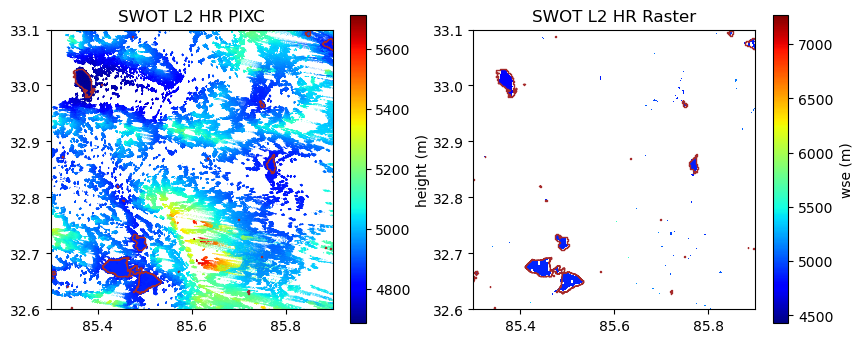

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
# ax1
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
           s=0.1, edgecolor='none', cmap='jet')
lake_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
ax[0].set_xlim(85.3, 85.9); ax[0].set_ylim(32.6, 33.1)
ax[0].set_title('SWOT L2 HR PIXC')
# ax2
im2 = ax[1].imshow(raster_wgs84_nc.wse.values, 
                   cmap='jet', extent=raster_extent)
lake_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
ax[1].set_xlim(85.3, 85.9); ax[1].set_ylim(32.6, 33.1)
ax[1].set_title('SWOT L2 HR Raster')
fig.colorbar(scat1, ax=ax[0]).set_label('height (m)')
fig.colorbar(im2, ax=ax[1]).set_label('wse (m)')
